In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy import stats
import warnings

def invboxcox(y,lmbda):
    if lmbda == 0:
        return(np.exp(y))
    else:
        return(np.exp(np.log(lmbda*y+1)/lmbda))

Загружаем данные 

In [2]:
wages = pd.read_csv('WAG_C_M.csv', delimiter=";", index_col=['month'], parse_dates=['month'], dayfirst=True)

In [3]:
wages.head()

,WAG_C_M
month,
1993-01-01,15.3
1993-02-01,19.1
1993-03-01,23.6
1993-04-01,30.6
1993-05-01,37.5


Посмотрим на ряд и проведем визуальный анализ

Populating the interactive namespace from numpy and matplotlib


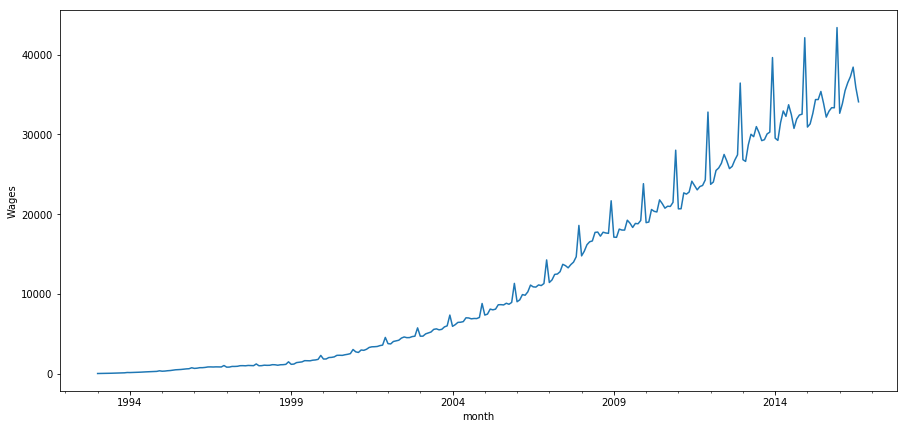

In [4]:
%pylab inline

wages.WAG_C_M = wages.WAG_C_M
plt.figure(figsize(15,7))
wages.WAG_C_M.plot()
plt.ylabel('Wages')
pylab.show()

По графику видно, наличие тренда и сезонности и необходмость стабилизации дисперсии

Критерий Дики-Фуллера: p=0.991850


<Figure size 1080x720 with 0 Axes>

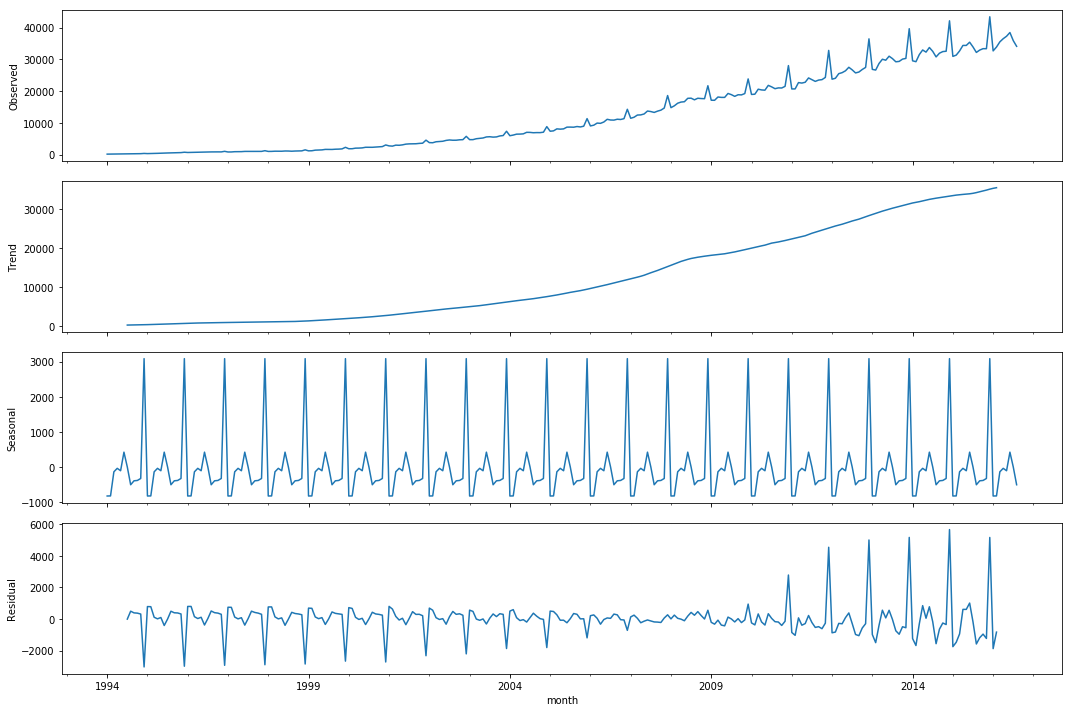

In [5]:
plt.figure(figsize(15,10));
sm.tsa.seasonal_decompose(wages.WAG_C_M[12:]).plot();
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(wages.WAG_C_M)[1]);

Критерий Дики-Фуллера показывает, что ряд нестационарен

## Стабилизация дисперсии
Выполним преобразование Бокса-Кокса

Оптимальный параметр преобразования Бокса-Кокса: 0.263202
Критерий Дики-Фуллера: p=0.696899


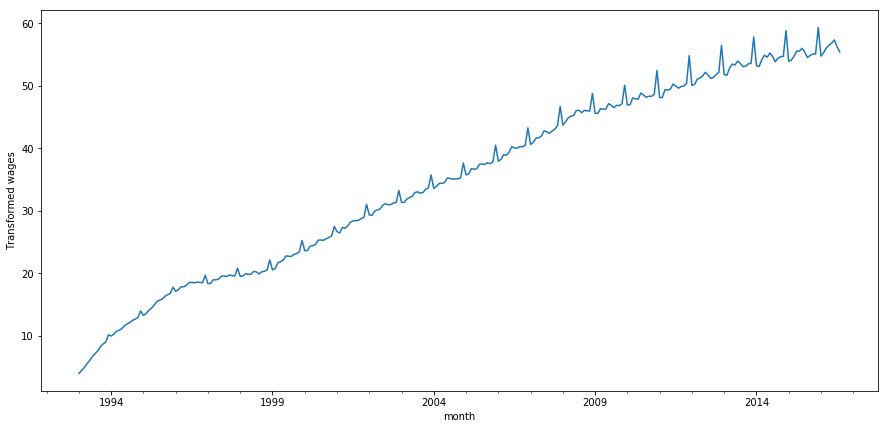

In [6]:
wages['WAG_C_M_box'], lmbda = stats.boxcox(wages.WAG_C_M)
plt.figure(figsize(15,7))
wages.WAG_C_M_box.plot()
plt.ylabel(u'Transformed wages')
print("Оптимальный параметр преобразования Бокса-Кокса: %f" % lmbda)
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(wages.WAG_C_M_box)[1])

Видим, что дисперсия все-еще есть, но явно меньше

## Приведение к стационарности

Проведем сезонное диффиренциорование:

Критерий Дики-Фуллера: p=0.014697


<Figure size 1080x720 with 0 Axes>

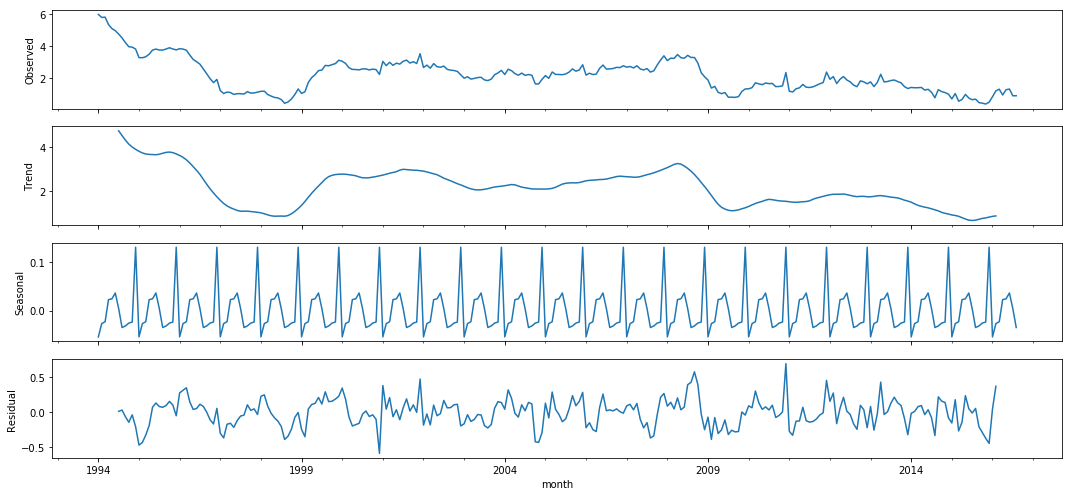

In [7]:
wages['wages_box_diff'] = wages.WAG_C_M_box - wages.WAG_C_M_box.shift(12)
plt.figure(figsize=(15,10))
sm.tsa.seasonal_decompose(wages.wages_box_diff[12:]).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(wages.wages_box_diff[12:])[1])

Критерий Дики-Фуллера отвергает нестационарность, однако на графиках мы видим ярко-выраженное наличие тренда. Проведем обычное диффиренцирование

Критерий Дики-Фуллера: p=0.000000


<Figure size 1080x720 with 0 Axes>

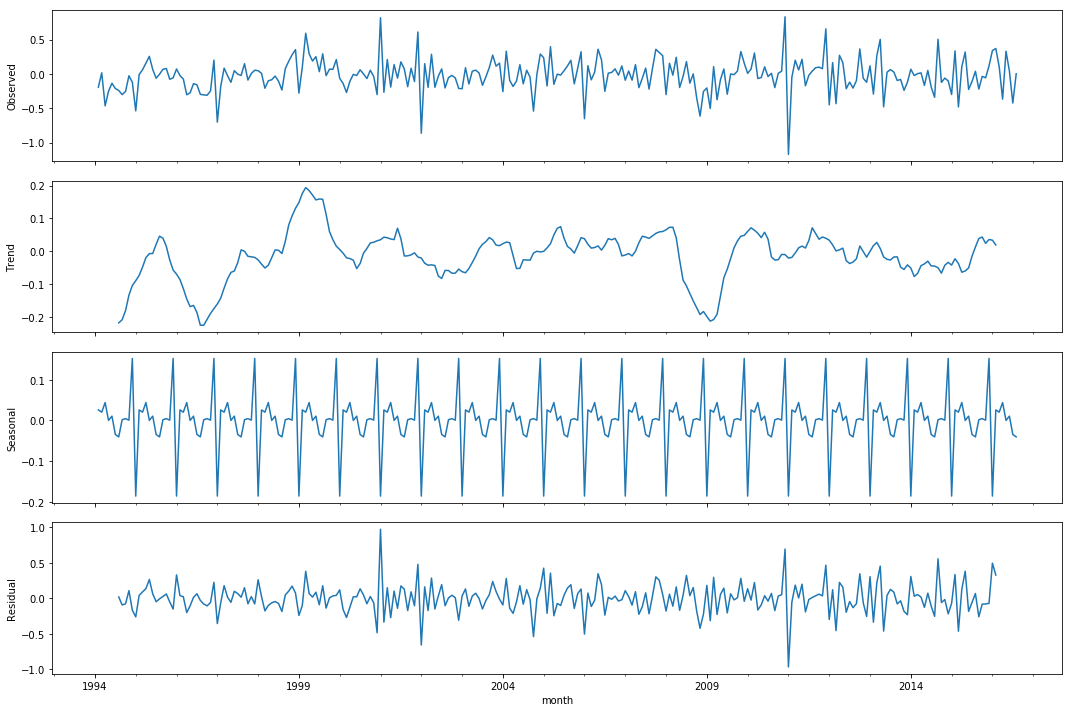

In [8]:
wages['wages_box_diff2'] = wages.wages_box_diff - wages.wages_box_diff.shift(1)
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(wages.wages_box_diff2[13:]).plot()   
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(wages.wages_box_diff2[13:])[1])

Гипотеза о нестационарности отвергается, тренда больше нет

## Выбор начальных приближений для p, q, P, Q

Посмотрим на ACF и PACF полученного ряда

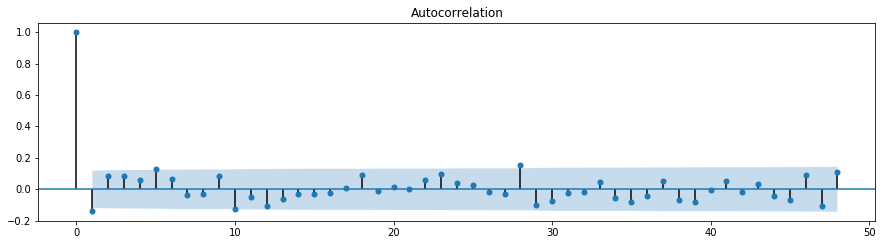

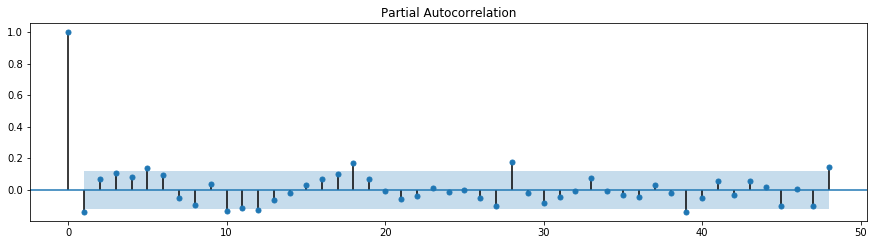

In [9]:
plt.figure(figsize(15,8))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(wages.wages_box_diff2[13:].values.squeeze(), lags=48, ax=ax)
pylab.show()
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(wages.wages_box_diff2[13:].values.squeeze(), lags=48, ax=ax)
pylab.show()

Начальные приближения: Q=0, q=1, P=4, p=5

In [10]:
ps = range(0, 6)
d=1
qs = range(0, 2)
Ps = range(0, 5)
D=1
Qs = range(0, 1)

In [11]:
ps = range(0, 11)
qs = range(0, 11)
Ps = range(0, 2)
Qs = range(0, 1)
d = 1
D = 1

In [12]:
from itertools import product
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

242

In [13]:
%%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(wages.WAG_C_M_box, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

wrong parameters: (1, 2, 0, 0)
wrong parameters: (1, 2, 1, 0)
wrong parameters: (2, 1, 0, 0)
wrong parameters: (2, 1, 1, 0)
wrong parameters: (2, 2, 0, 0)
wrong parameters: (2, 2, 1, 0)
wrong parameters: (3, 2, 0, 0)
wrong parameters: (3, 2, 1, 0)
wrong parameters: (3, 10, 0, 0)
wrong parameters: (3, 10, 1, 0)
wrong parameters: (4, 2, 0, 0)
wrong parameters: (4, 2, 1, 0)
wrong parameters: (4, 4, 0, 0)
wrong parameters: (4, 4, 1, 0)
wrong parameters: (4, 10, 0, 0)
wrong parameters: (4, 10, 1, 0)
wrong parameters: (5, 2, 0, 0)
wrong parameters: (5, 2, 1, 0)
wrong parameters: (5, 3, 0, 0)
wrong parameters: (5, 3, 1, 0)
wrong parameters: (5, 4, 0, 0)
wrong parameters: (5, 4, 1, 0)
wrong parameters: (5, 9, 0, 0)
wrong parameters: (5, 9, 1, 0)
wrong parameters: (6, 3, 0, 0)
wrong parameters: (6, 3, 1, 0)
wrong parameters: (6, 4, 0, 0)
wrong parameters: (6, 4, 1, 0)
wrong parameters: (6, 7, 0, 0)
wrong parameters: (6, 7, 1, 0)
wrong parameters: (6, 8, 0, 0)
wrong parameters: (6, 8, 1, 0)
wron

In [14]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

       parameters        aic
99   (5, 5, 1, 0) -24.855059
87   (4, 6, 1, 0) -24.562981
85   (4, 5, 1, 0) -24.011564
115  (6, 5, 1, 0) -22.703311
89   (4, 7, 1, 0) -22.242966


In [15]:
print('Лучшая модель: ' , best_model.summary())

Лучшая модель:                                   Statespace Model Results                                 
Dep. Variable:                        WAG_C_M_box   No. Observations:                  284
Model:             SARIMAX(5, 1, 5)x(1, 1, 0, 12)   Log Likelihood                  24.428
Date:                            Wed, 10 Jul 2019   AIC                            -24.855
Time:                                    09:35:20   BIC                             18.370
Sample:                                01-01-1993   HQIC                            -7.500
                                     - 08-01-2016                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2191      0.560     -0.391      0.696      -1.317       0.879
ar.L2          0.23

Остатки:

Критерий Стьюдента: p=0.167503
Критерий Дики-Фуллера: p=0.000000


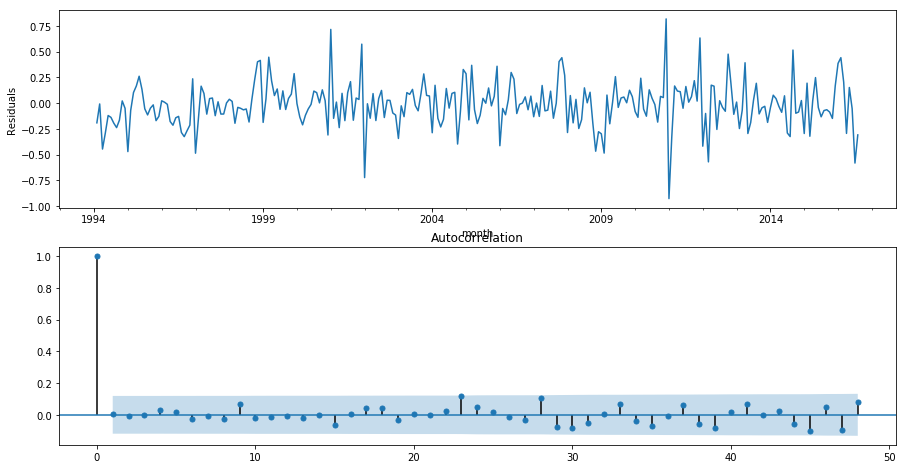

In [16]:
plt.figure(figsize(15,8))
plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=48, ax=ax)

print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model.resid[13:], 0)[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1])

Остатки несмещены - критерий Стьюдента (p-value = 0.3), стационарны - критерий Дикки-Фуллера (p-value = 0), неавтокоррелированы - критерий Льюнга-Бокса (p-value = 0)

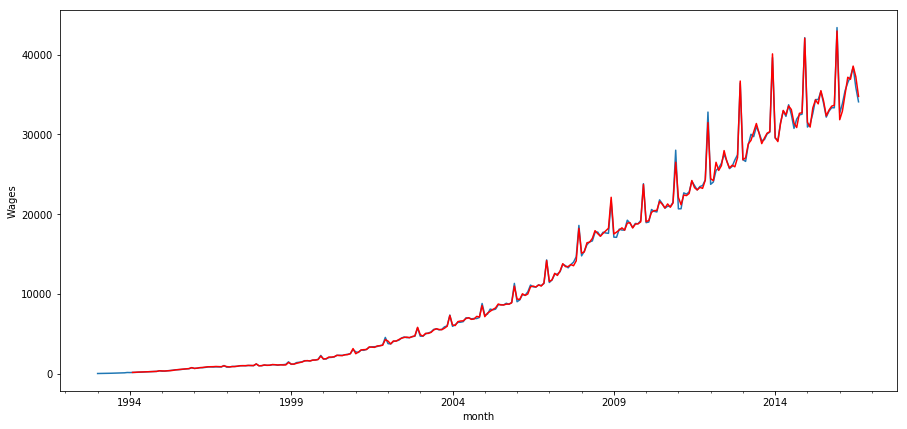

In [17]:
# Посмотрим,как модель описывает данные: 

wages['model'] = invboxcox(best_model.fittedvalues, lmbda)
plt.figure(figsize(15,7))
wages.WAG_C_M.plot()
wages.model[13:].plot(color='r')
plt.ylabel('Wages')
pylab.show()

## Прогноз

In [18]:
wages.tail(5)

,WAG_C_M,WAG_C_M_box,wages_box_diff,wages_box_diff2,model
month,,,,,
2016-04-01,36497.0,56.526742,0.942729,-0.366210,37179.402018
2016-05-01,37270.0,56.860441,1.275065,0.332336,36918.025359
2016-06-01,38447.0,57.358885,1.316994,0.041929,38577.012265
2016-07-01,35888.0,56.260153,0.893671,-0.423323,37229.499901
2016-08-01,34095.0,55.455409,0.896620,0.002949,34776.349327


In [19]:
wages.shape

(284, 5)

Объем выборки составляет 284 объекта, дата последней регистрации зарплатных данных - 2016-08-01

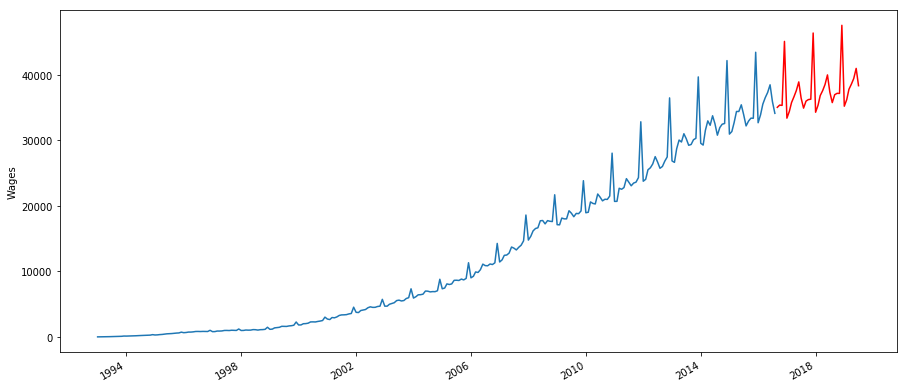

In [20]:
wages_2 = wages[['WAG_C_M']]
date_list = [datetime.datetime.strptime("2016-08-01", "%Y-%m-%d") + relativedelta(months=x) for x in range(0,36)]
future = pd.DataFrame(index=date_list, columns= wages_2.columns)
wages_2 = pd.concat([wages_2, future])
wages_2['forecast'] = invboxcox(best_model.predict(start=284, end=284+35), lmbda)

plt.figure(figsize(15,7))
wages_2.WAG_C_M.plot()
wages_2.forecast.plot(color='r')
plt.ylabel('Wages')
pylab.show()

Результаты прогноза выглядят органично, не выбиваются из общей тенденции и сезонности